<a href="https://colab.research.google.com/github/nasiksami/FYP2-Codes/blob/main/EfficientNetB0(94%25).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Wed Nov 25 19:58:02 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:

import psutil
import humanize
import os
from IPython.display import display_html
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
print(os.listdir())
dataDirectory= "/content/drive/MyDrive/dataset_resized" 
print(os.listdir(dataDirectory))

['.config', 'drive', 'sample_data']
['testing', 'training', 'models', 'SAVED_MODELS']


In [3]:
!rm -r ~/.keras
!mkdir ~/.keras
!mkdir ~/.keras/models
# not enough space for both
#!cp ../input/keras-pretrained-models/* ~/.keras/models/ 
#!cp ../input/vgg19/* ~/.keras/models
!cp ../input/keras-pretrained-models/*notop* ~/.keras/models/
!cp ../input/keras-pretrained-models/imagenet_class_index.json ~/.keras/models/
#!cp ../input/keras-pretrained-models/resnet50* ~/.keras/models/

cp: cannot stat '../input/keras-pretrained-models/*notop*': No such file or directory
cp: cannot stat '../input/keras-pretrained-models/imagenet_class_index.json': No such file or directory


In [79]:
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.models import Model
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dropout
from keras.layers.convolutional import *
from keras.callbacks import ModelCheckpoint
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.applications.inception_v3 import decode_predictions
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from keras.preprocessing.image import load_img,img_to_array
from keras.models import model_from_json
import itertools
import matplotlib.pyplot as plt
import time
import pandas as pd
%matplotlib inline
import skimage.io
import os 
import glob
import tqdm
import tensorflow

In [5]:
train_path = dataDirectory+'/training'
test_path  = dataDirectory+'/testing'
print(os.listdir(train_path))
print(os.listdir(test_path))

['ewaste', 'cardboard', 'glass', 'paper', 'metal', 'trash', 'plastic']
['trash', 'metal', 'plastic', 'ewaste', 'cardboard', 'glass', 'paper']


In [6]:
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        fill_mode='nearest',
        validation_split=0.2) # set validation split

In [7]:
selectedClasses = [ 'cardboard','ewaste', 'glass', 'metal','paper', 'plastic', 'trash'] 

In [8]:
batchSize=64

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=batchSize,
    classes=selectedClasses,
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_path, # same directory as training data
    target_size=(224, 224),
    batch_size=batchSize,
    classes=selectedClasses,
    subset='validation') # set as validation data

test_generator = ImageDataGenerator().flow_from_directory(
    test_path, 
    target_size=(224,224), 
    classes=selectedClasses,
    shuffle= False,
    batch_size = batchSize)# set as test data

Found 1933 images belonging to 7 classes.
Found 481 images belonging to 7 classes.
Found 608 images belonging to 7 classes.


In [9]:
print ("In train_generator ")
for cls in range(len (train_generator.class_indices)):
    print(selectedClasses[cls],":\t",list(train_generator.classes).count(cls))
print ("") 

print ("In validation_generator ")
for cls in range(len (validation_generator.class_indices)):
    print(selectedClasses[cls],":\t",list(validation_generator.classes).count(cls))
print ("") 

print ("In test_generator ")
for cls in range(len (test_generator.class_indices)):
    print(selectedClasses[cls],":\t",list(test_generator.classes).count(cls))

In train_generator 
cardboard :	 258
ewaste :	 316
glass :	 320
metal :	 263
paper :	 380
plastic :	 308
trash :	 88

In validation_generator 
cardboard :	 64
ewaste :	 79
glass :	 80
metal :	 65
paper :	 95
plastic :	 77
trash :	 21

In test_generator 
cardboard :	 81
ewaste :	 100
glass :	 101
metal :	 82
paper :	 119
plastic :	 97
trash :	 28


In [10]:
#plots images with labels within jupyter notebook
def plots(ims, figsize = (22,22), rows=4, interp=False, titles=None, maxNum = 9):
    if type(ims[0] is np.ndarray):
        ims = np.array(ims).astype(np.uint8)
        if(ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
           
    f = plt.figure(figsize=figsize)
    #cols = len(ims) //rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    cols = maxNum // rows if maxNum % 2 == 0 else maxNum//rows + 1
    #for i in range(len(ims)):
    for i in range(maxNum):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=20)
        plt.imshow(ims[i], interpolation = None if interp else 'none')   

In [11]:
train_generator.reset()
imgs, labels = train_generator.next()

#print(labels)

labelNames=[]
labelIndices=[np.where(r==1)[0][0] for r in labels]
#print(labelIndices)

for ind in labelIndices:
    for labelName,labelIndex in train_generator.class_indices.items():
        if labelIndex == ind:
            #print (labelName)
            labelNames.append(labelName)

#labels

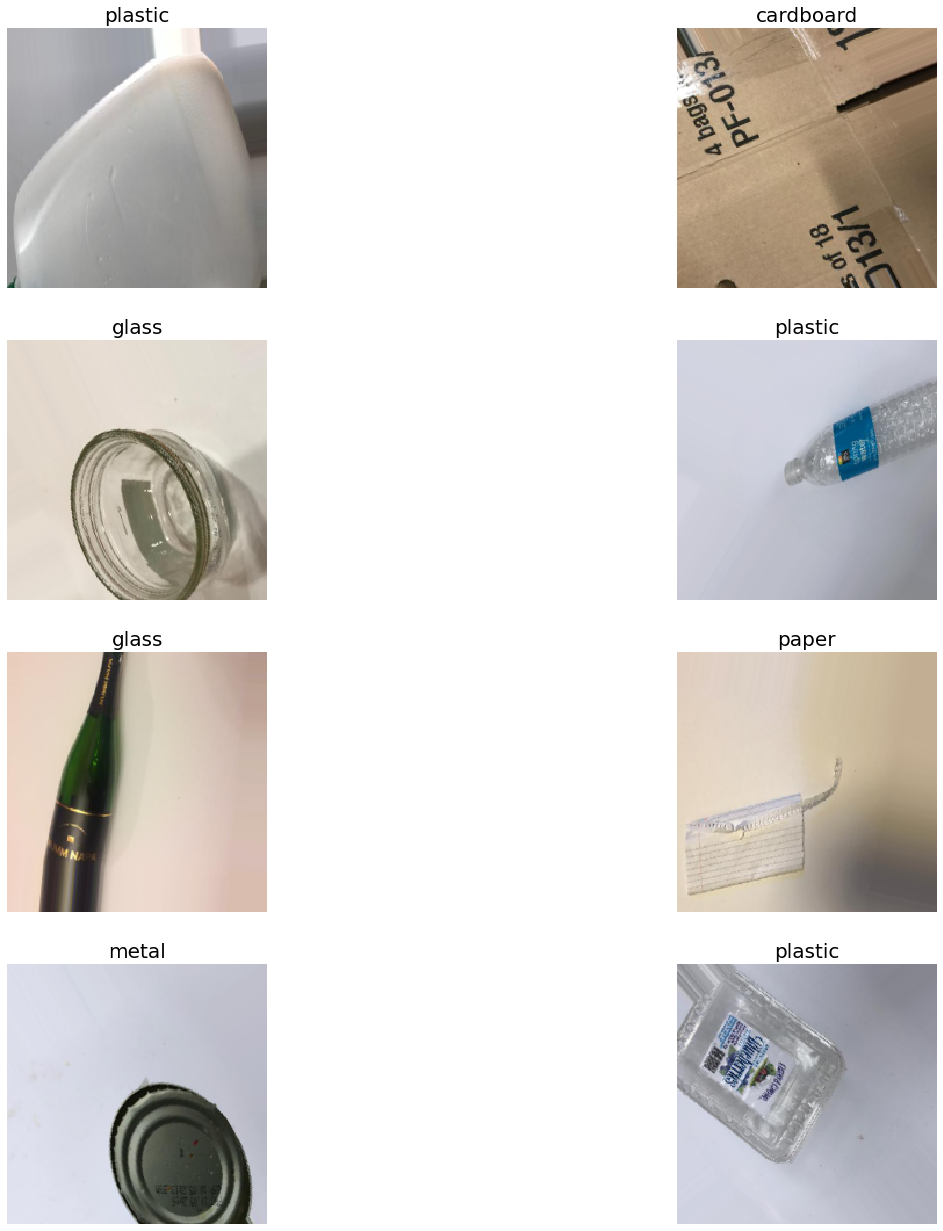

In [12]:
plots(imgs, rows=4, titles = labelNames, maxNum=8)

In [13]:
from tensorflow.keras.applications import EfficientNetB0
model = EfficientNetB0(weights='imagenet')

21839872/21834768 [==============================] - 0s 0us/step


In [14]:
# Create the base model from the pre-trained model MobileNet V2
import tensorflow as tf
base_model = tf.keras.applications.EfficientNetB0(input_shape=(224, 224, 3),include_top=False,weights='imagenet')



16711680/16705208 [==============================] - 0s 0us/step


In [15]:
base_model.trainable = False

In [16]:
x = Flatten()(base_model.output)

In [17]:
prediction = Dense(7, activation='softmax')(x)

# create a model object
model = Model(inputs=base_model.input, outputs=prediction)

In [18]:
# view the structure of the model
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 224, 224, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 224, 224, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_1[0][0]            
_______________________________________________________________________________________

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [20]:
#Atutomatic rename with epoch number and val accuracy:
#filepath="checkpoints/weights-improvement-epeoch-{epoch:02d}-val_acc-{val_acc:.2f}.hdf5"


 
modelName= "EfficientNetB0"
#save the best weights over the same file with the model name

#filepath="checkpoints/"+modelName+"_bestweights.hdf5"
filepath=modelName+"_bestweights.hdf5"
earlystopping = EarlyStopping(monitor = 'val_accuracy', 
                              mode = 'max' , 
                              patience = 10,
                              verbose = 1)
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [earlystopping,checkpoint]

In [24]:
model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
stepsPerEpoch= (train_generator.samples+ (batchSize-1)) // batchSize
print("stepsPerEpoch: ", stepsPerEpoch)

validationSteps=(validation_generator.samples+ (batchSize-1)) // batchSize
print("validationSteps: ", validationSteps)


stepsPerEpoch:  31
validationSteps:  8


In [26]:
train_generator.reset()
validation_generator.reset()

# Fit the model
history = model.fit_generator(
    train_generator, 
    validation_data = validation_generator,
    epochs = 50,
    steps_per_epoch = stepsPerEpoch,
    validation_steps= validationSteps,
    callbacks=callbacks_list,
    verbose=1)

Epoch 1/50
31/31 [==============================] - 843s 27s/step - loss: 2.0773 - accuracy: 0.6570 - val_loss: 2.1774 - val_accuracy: 0.7214
Epoch 2/50
31/31 [==============================] - 43s 1s/step - loss: 1.1193 - accuracy: 0.8184 - val_loss: 1.7838 - val_accuracy: 0.7360
Epoch 3/50
31/31 [==============================] - 44s 1s/step - loss: 0.9249 - accuracy: 0.8407 - val_loss: 1.8194 - val_accuracy: 0.7464
Epoch 4/50
31/31 [==============================] - 45s 1s/step - loss: 0.9928 - accuracy: 0.8396 - val_loss: 2.0662 - val_accuracy: 0.7588
Epoch 5/50
31/31 [==============================] - 44s 1s/step - loss: 0.6138 - accuracy: 0.8971 - val_loss: 2.0610 - val_accuracy: 0.7672
Epoch 6/50
31/31 [==============================] - 44s 1s/step - loss: 0.7508 - accuracy: 0.8914 - val_loss: 2.2572 - val_accuracy: 0.7484
Epoch 7/50
31/31 [==============================] - 44s 1s/step - loss: 0.7282 - accuracy: 0.8919 - val_loss: 2.2336 - val_accuracy: 0.7734
Epoch 8/50
31/31 [

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


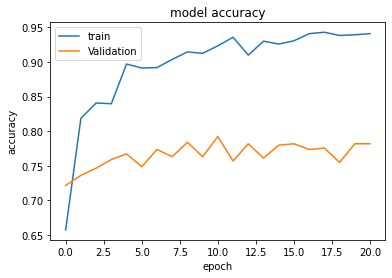

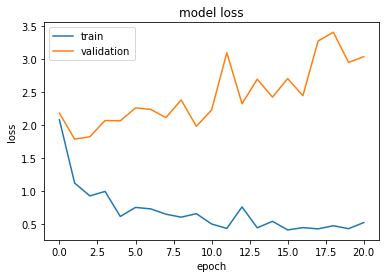

In [27]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [28]:
validation_generator.reset()
score = model.evaluate_generator(validation_generator, (validation_generator.samples + (batchSize-1)) //batchSize)
print("For validation data set; Loss: ",score[0]," Accuracy: ", score[1])

Instructions for updating:
Please use Model.evaluate, which supports generators.
For validation data set; Loss:  3.015019178390503  Accuracy:  0.7671517729759216


In [29]:
test_generator.reset()
score = model.evaluate_generator(test_generator, (test_generator.samples + (batchSize-1)) // batchSize)
print("For test data set; Loss: ",score[0]," Accuracy: ", score[1])

For test data set; Loss:  2.045562505722046  Accuracy:  0.8552631735801697


In [46]:
train_generator.reset()
score = model.evaluate_generator(train_generator, (train_generator.samples + (batchSize-1)) // batchSize)
print("For training data set; Loss: ",score[0]," Accuracy: ", score[1])

For training data set; Loss:  0.46815869212150574  Accuracy:  0.9436109662055969


In [58]:
test_generator.reset()
testStep = (test_generator.samples + (batchSize-1)) // batchSize
print("testStep: ", testStep)
predictions = model.predict_generator(test_generator, steps = testStep ,  verbose = 1)
len(predictions)

testStep:  10
10/10 [==============================] - 6s 561ms/step


608

In [59]:
len(predictions)

608

In [60]:
predicted_class_indices=np.argmax(predictions,axis=1)
print(predicted_class_indices)
len(predicted_class_indices)

[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 6 0 0 0 4 0 0 0 0 0 0 0 6 0 0 0 0
 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 2 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2
 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 5 2 2 2 2 5 2 2 2 2 3 2 2 2 2 3 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 6 3 3 3 3 3 3 3 6 3 2 3 3 3 2
 2 3 3 3 3 3 3 3 5 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 6 3 3 3 3 3 3
 3 3 6 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 6 3 3 3 3 3 3 2 3 3 0 4 4 4 4 4
 4 4 4 4 4 5 4 0 5 4 4 5 0 4 4 4 4 4 4 4 4 4 4 4 4 6 6 4 0 4 4 4 4 4 6 6 4
 4 4 4 4 4 4 5 4 4 4 4 4 4 1 4 4 4 4 4 4 4 0 5 4 4 4 4 4 4 4 4 4 4 4 0 4 4
 4 4 4 4 4 3 4 6 4 4 4 4 4 4 6 4 4 4 4 0 0 4 1 1 4 4 0 4 4 6 4 4 4 4 4 6 4
 4 4 5 5 5 5 4 5 2 2 5 2 

608

In [61]:
labels = (test_generator.class_indices)
print(labels)

{'cardboard': 0, 'ewaste': 1, 'glass': 2, 'metal': 3, 'paper': 4, 'plastic': 5, 'trash': 6}


In [62]:
labels = dict((v,k) for k,v in labels.items())
print(labels)

{0: 'cardboard', 1: 'ewaste', 2: 'glass', 3: 'metal', 4: 'paper', 5: 'plastic', 6: 'trash'}


In [63]:
predictedLables= [labels[k] for k in predicted_class_indices]
print(predictedLables)
len(predictedLables)

['cardboard', 'cardboard', 'cardboard', 'ewaste', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'paper', 'cardboard', 'cardboard', 'cardboard', 'trash', 'cardboard', 'cardboard', 'cardboard', 'paper', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'trash', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'paper', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'plastic', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'metal', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', '

608

In [64]:
actualLables= [labels[k] for k in test_generator.classes]
print(actualLables)
len(actualLables)

['cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard'

608

In [65]:
accuracy_score(actualLables, predictedLables)

0.8552631578947368

In [66]:
matrix = confusion_matrix(actualLables, predictedLables)
print(labels)
matrix

{0: 'cardboard', 1: 'ewaste', 2: 'glass', 3: 'metal', 4: 'paper', 5: 'plastic', 6: 'trash'}


array([[72,  1,  0,  1,  4,  1,  2],
       [ 0, 98,  2,  0,  0,  0,  0],
       [ 0,  0, 93,  5,  0,  2,  1],
       [ 0,  0,  5, 72,  0,  1,  4],
       [ 9,  3,  0,  1, 93,  5,  8],
       [ 0,  2, 15,  4,  3, 68,  5],
       [ 0,  1,  1,  1,  0,  1, 24]])

In [67]:
print(classification_report(actualLables, predictedLables))

              precision    recall  f1-score   support

   cardboard       0.89      0.89      0.89        81
      ewaste       0.93      0.98      0.96       100
       glass       0.80      0.92      0.86       101
       metal       0.86      0.88      0.87        82
       paper       0.93      0.78      0.85       119
     plastic       0.87      0.70      0.78        97
       trash       0.55      0.86      0.67        28

    accuracy                           0.86       608
   macro avg       0.83      0.86      0.84       608
weighted avg       0.87      0.86      0.86       608



In [68]:
recall_score( actualLables, predictedLables,average='weighted') 

0.8552631578947368

In [69]:
precision_score( actualLables, predictedLables,average='weighted') 

0.8669408147811051

In [70]:
#Prepared code that is taken from SKLearn Website, Creates Confusion Matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[72  1  0  1  4  1  2]
 [ 0 98  2  0  0  0  0]
 [ 0  0 93  5  0  2  1]
 [ 0  0  5 72  0  1  4]
 [ 9  3  0  1 93  5  8]
 [ 0  2 15  4  3 68  5]
 [ 0  1  1  1  0  1 24]]


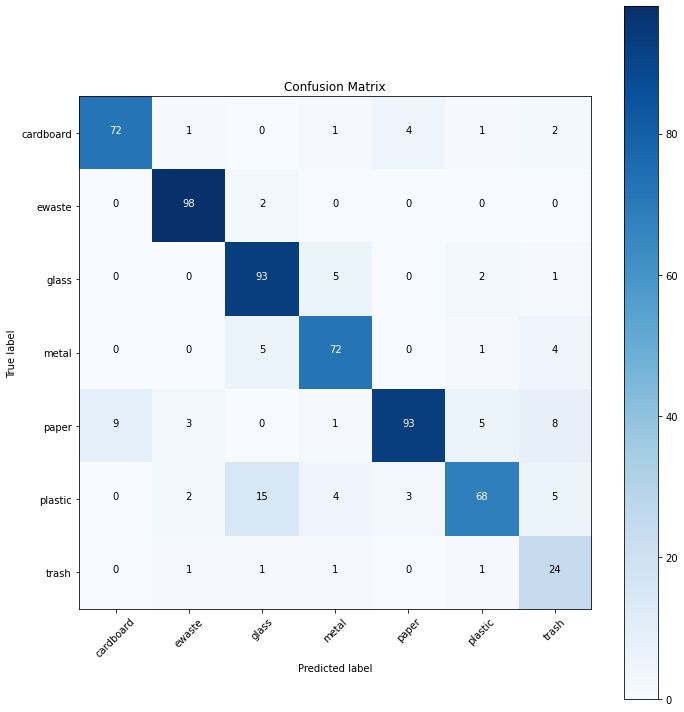

In [71]:
plt.figure(figsize=(10,10))
cm_plot_labels = selectedClasses
plot_confusion_matrix(matrix,cm_plot_labels, normalize=False
                      , title = 'Confusion Matrix')


In [73]:
from tensorflow.keras.models import load_model

model.save('/content/drive/MyDrive/(94%)EfficientNetB0.h5')